In [38]:
import torch 
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable

In [39]:
# Hyper Parameters
num_epochs = 5
batch_size = 100
learning_rate = 0.001

In [40]:
# MNIST Dataset
train_dataset = dsets.MNIST(root='./data/',
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./data/',
                           train=False, 
                           transform=transforms.ToTensor())

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

In [41]:
# CNN Model (2 conv layer)
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(7*7*32, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

cnn = CNN()

In [42]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 48, kernel_size=5, padding=2)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(2, return_indices=True)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out, indices = self.maxpool1(out)
        return out, indices

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.unpool1 = nn.MaxUnpool2d(2)
        self.deconv1 = nn.ConvTranspose2d(48, 1, kernel_size=5, padding=2)

    def forward(self, x, indices):
        out = self.unpool1(x, indices)
        out = self.deconv1(out)
        return out   

encoder = Encoder()
decoder = Decoder()

In [43]:
# Loss and Optimizer
criterion = nn.MSELoss()
# criterion = nn.CrossEntropyLoss()
params = list(decoder.parameters()) + list(encoder.parameters())
optimizer = torch.optim.Adam(params, lr=learning_rate)

In [52]:
# Train the Model and break it pre-maturely to view the first reconstruction
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images)
#         labels = Variable(labels)
        
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs, indices = encoder(images)
        outputs = decoder(outputs, indices)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f' 
                   %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0]))
        
        break

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline

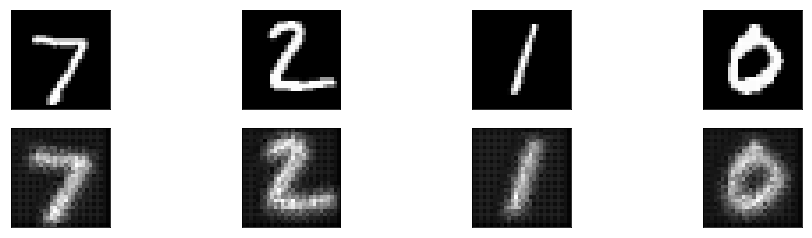

In [54]:
# View the results
# Test the Model
encoder.eval()
decoder.eval()

# total images to display
n = 5
plt.figure(figsize=(20, 4))

for images, labels in test_loader:
    
    images = Variable(images)
    outputs, indices = encoder(images)
    outputs = decoder(outputs, indices)
    count = 0
    
    in_out = zip(images, outputs)
    for image, output in in_out:
        count += 1
        if count >= n:
            break
            
        # display original images    
        ax = plt.subplot(2, n, count + 1)
        plt.imshow(image.data.numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display reconstruction
        ax = plt.subplot(2, n, count + 1 + n)
        plt.imshow(output.data.numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)   
            
    break


In [55]:
# Train the Model (fully)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images)
#         labels = Variable(labels)
        
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs, indices = encoder(images)
        outputs = decoder(outputs, indices)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f' 
                   %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0]))
        

Epoch [1/5], Iter [100/600] Loss: 0.0021
Epoch [1/5], Iter [200/600] Loss: 0.0013
Epoch [1/5], Iter [300/600] Loss: 0.0010
Epoch [1/5], Iter [400/600] Loss: 0.0009
Epoch [1/5], Iter [500/600] Loss: 0.0008
Epoch [1/5], Iter [600/600] Loss: 0.0007
Epoch [2/5], Iter [100/600] Loss: 0.0007
Epoch [2/5], Iter [200/600] Loss: 0.0006
Epoch [2/5], Iter [300/600] Loss: 0.0006
Epoch [2/5], Iter [400/600] Loss: 0.0005
Epoch [2/5], Iter [500/600] Loss: 0.0005
Epoch [2/5], Iter [600/600] Loss: 0.0006
Epoch [3/5], Iter [100/600] Loss: 0.0005
Epoch [3/5], Iter [200/600] Loss: 0.0005
Epoch [3/5], Iter [300/600] Loss: 0.0005
Epoch [3/5], Iter [400/600] Loss: 0.0004
Epoch [3/5], Iter [500/600] Loss: 0.0004
Epoch [3/5], Iter [600/600] Loss: 0.0004
Epoch [4/5], Iter [100/600] Loss: 0.0004
Epoch [4/5], Iter [200/600] Loss: 0.0004
Epoch [4/5], Iter [300/600] Loss: 0.0004
Epoch [4/5], Iter [400/600] Loss: 0.0004
Epoch [4/5], Iter [500/600] Loss: 0.0004
Epoch [4/5], Iter [600/600] Loss: 0.0004
Epoch [5/5], Ite

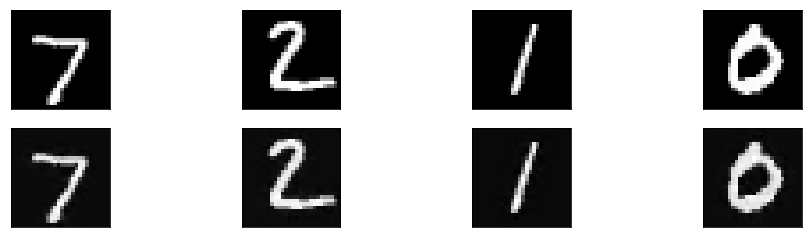

In [56]:
# View the results
# Test the Model
encoder.eval()
decoder.eval()

# total images to display
n = 5
plt.figure(figsize=(20, 4))

for images, labels in test_loader:
    
    images = Variable(images)
    outputs, indices = encoder(images)
    outputs = decoder(outputs, indices)
    count = 0
    
    in_out = zip(images, outputs)
    for image, output in in_out:
        count += 1
        if count >= n:
            break
            
        # display original images    
        ax = plt.subplot(2, n, count + 1)
        plt.imshow(image.data.numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display reconstruction
        ax = plt.subplot(2, n, count + 1 + n)
        plt.imshow(output.data.numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)   
            
    break


In [57]:
# Save the Trained Model
torch.save(encoder.state_dict(), 'encoder.pkl')
torch.save(decoder.state_dict(), 'decoder.pkl')


In [58]:
reconstruction_loss = nn.MSELoss()

In [59]:
encoder.eval()
decoder.eval()
test_loss = 0
for data, _ in test_loader:

    data = Variable(data, volatile=True)
    out, indices = encoder(data)
    out = decoder(out, indices)
    test_loss += reconstruction_loss(out, data).data[0]

test_loss /= len(test_loader.dataset)
print('====> Test set loss', test_loss)



====> Test set loss 3.374186542350799e-06
